In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score,\
    recall_score, f1_score, log_loss
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
import shap

from numpy.typing import ArrayLike
from typing import TypeAlias

from metrics import get_metrics, check_overfitting

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

RAND = 10

In [2]:
ROOT = "../"

RAND = 10
N_SPLIT_TRAIN = 0.18
N_SPLIT_VAL = 0.15
N_FOLDS = 5

# Overview

Данные взяты из соревания на Kaggle. Основная информация по данным представлена здесь https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/data

Цель - предсказать, какие клиенты с большей вероятностью не смогут выплатить свои кредиты. Оценка должна быть стабильна с течением времени

Посмотрим на важность признаков при предсказании.

# Prepare data

In [3]:
df_train = pd.read_parquet(f"{ROOT}train4.parquet")
df_test = pd.read_parquet(f"{ROOT}test4.parquet")

In [4]:
cat_columns = df_train.select_dtypes("object").columns.to_list()
df_train[cat_columns] = df_train[cat_columns].astype("category")
df_test[cat_columns] = df_test[cat_columns].astype("category")

category_features = df_train.select_dtypes("category").columns.to_list()

In [5]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

Т.к. метрика стабильности gini рассчитывается для каждого значениям WEEK_NUM, то будем делить датасет в разрезе WEEK_NUM, чтобы значения WEEK_NUM не пересакались в тестовом и тренировочном датасете

In [6]:
def train_test_split_by_groups(X: pd.DataFrame,
                               y: pd.Series,
                               groups: pd.Series,
                               test_size=None,
                               train_size=None,
                               random_state=None,
                               shuffle=True):
    """
    Split arrays or matrices into random train and test subsets 
    according groups.
    """
    if shuffle:
        gss = GroupShuffleSplit(n_splits=1,
                                test_size=test_size,
                                train_size=train_size,
                                random_state=random_state)
        train_idx, test_idx = next(gss.split(X, y, groups))
        return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx],\
            y.iloc[test_idx], groups.iloc[train_idx], groups.iloc[test_idx]
    else:
        return train_test_split(X,
                                y,
                                groups,
                                test_size=test_size,
                                train_size=train_size,
                                shuffle=False,
                                random_state=RAND)

In [7]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split_by_groups(
    X, 
    y, 
    weeks, 
    test_size=N_SPLIT_TRAIN, 
    random_state=RAND)

X_train_, X_val, y_train_, y_val, w_train_, w_val = train_test_split_by_groups(
    X_train,
    y_train,
    w_train, 
    test_size=N_SPLIT_VAL,
    random_state=RAND)

print(f"All train: {round(X_train.shape[0] / X.shape[0] * 100, 2)}%")
print(f"train: {round(X_train_.shape[0] / X.shape[0] * 100, 2)}%")
print(f"val: {round(X_val.shape[0] / X.shape[0] * 100, 2)}%")
print(f"test: {round(X_test.shape[0] / X.shape[0] * 100, 2)}%")

All train: 79.67%
train: 65.35%
val: 14.31%
test: 20.33%


# Training

Возьмем модель LGBMClassifier с 1000 estimators, т.к. она показывает хороший результат и в отличие от CatBoostClassifier выдает ответы значительно быстрее. 

In [8]:
%%time
params = {
    'n_estimators': 1000,
    'learning_rate': 0.201557703425373,
    'max_depth': 6,
    'min_child_samples': 59200,
    'reg_alpha': 1.5870626653704198,
    'reg_lambda': 0.08870954489127132,
    'colsample_bytree': 0.8987319208510414,
    'colsample_bynode': 0.8307150795884893,
    'objective': 'binary',
    'random_state': RAND,
    'verbose': -1
}

ratio = float(np.sum(y_train_ == 0)) / np.sum(y_train_ == 1)
eval_set = [(X_val, y_val)]

lgbm_clf = lgb.LGBMClassifier(scale_pos_weight=ratio, **params)

lgbm_clf.fit(X_train_,
             y_train_,
             eval_metric="auc",
             eval_set=eval_set,
             callbacks=[lgb.log_evaluation(100),
                        lgb.early_stopping(100)])

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.828699	valid_0's binary_logloss: 0.495632
[200]	valid_0's auc: 0.837621	valid_0's binary_logloss: 0.480437
[300]	valid_0's auc: 0.841139	valid_0's binary_logloss: 0.472396
[400]	valid_0's auc: 0.842448	valid_0's binary_logloss: 0.466635
[500]	valid_0's auc: 0.843347	valid_0's binary_logloss: 0.461673
[600]	valid_0's auc: 0.843923	valid_0's binary_logloss: 0.457801
[700]	valid_0's auc: 0.844187	valid_0's binary_logloss: 0.454921
[800]	valid_0's auc: 0.844498	valid_0's binary_logloss: 0.450981
[900]	valid_0's auc: 0.844599	valid_0's binary_logloss: 0.44832
Early stopping, best iteration is:
[872]	valid_0's auc: 0.844679	valid_0's binary_logloss: 0.449487
CPU times: total: 10min 19s
Wall time: 1min 49s


LGBMClassifier(colsample_bynode=0.8307150795884893,
               colsample_bytree=0.8987319208510414,
               learning_rate=0.201557703425373, max_depth=6,
               min_child_samples=59200, n_estimators=1000, objective='binary',
               random_state=10, reg_alpha=1.5870626653704198,
               reg_lambda=0.08870954489127132,
               scale_pos_weight=31.144624504655432, verbose=-1)

# Feature importance

In [ ]:
perm = permutation_importance(lgbm_clf,
                              X_test,
                              y_test,
                              random_state=RAND,
                              n_repeats=5)
perm_df = pd.DataFrame({
    'feature': list(X_test.columns),
    'value': perm['importances_mean']
}).sort_values(by='value', ascending=False)

In [22]:
perm_df[:30]

,feature,value
218,familystate_447L,0.008738
99,pmtnum_254L,0.007660
215,empl_employedfrom_271D,0.006687
198,max_numberofoverdueinstlmaxdat_641D,0.006506
12,avgdpdtolclosure24_3658938P,0.006294
8,applicationscnt_867L,0.006020
80,mobilephncnt_593L,0.005229
158,mean_amount_4527230A,0.005196
2,annuity_780A,0.004530
121,pmtscount_423L,0.004300


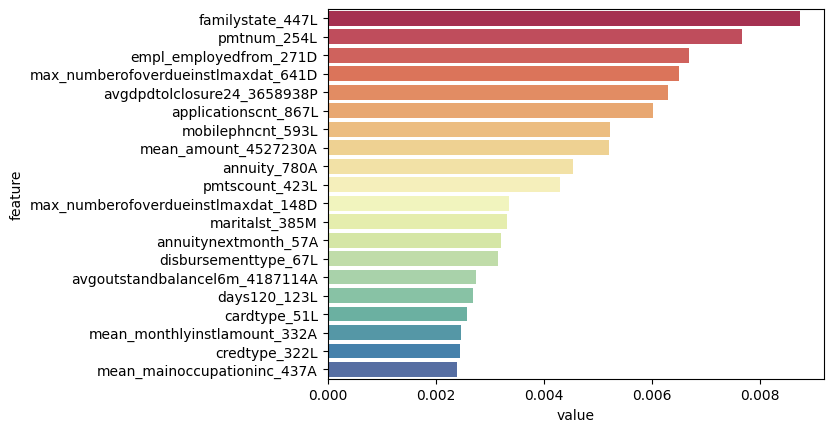

In [11]:
sns.barplot(data=perm_df[:20],
            x='value',
            y='feature',
            hue='feature',
            legend=False,
            palette="Spectral")
plt.show()

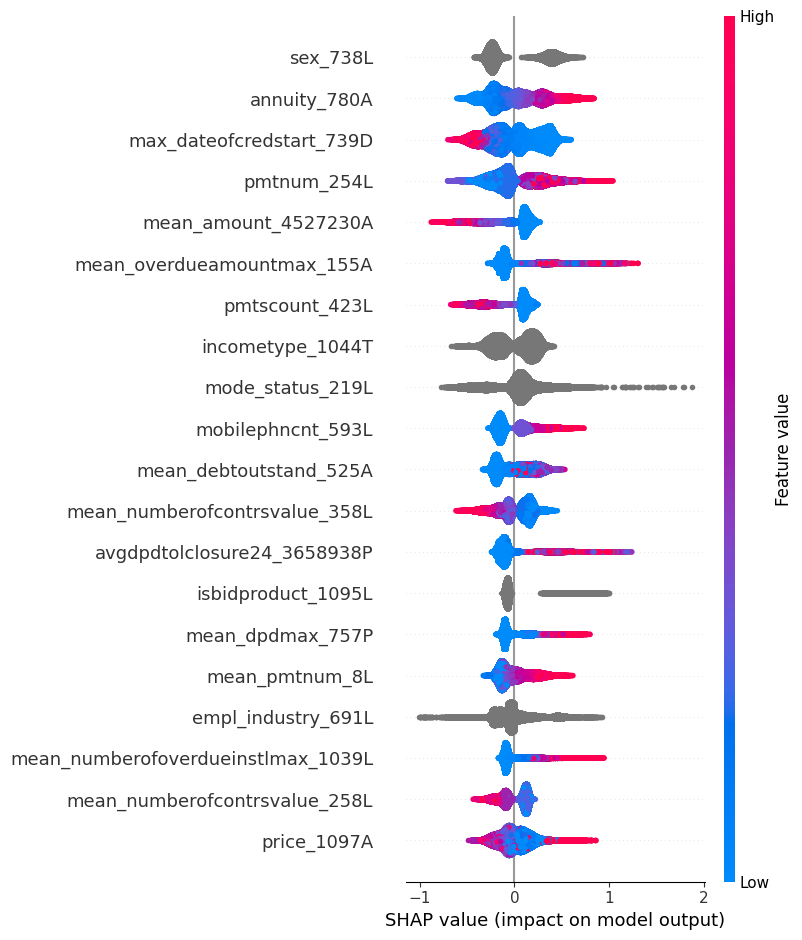

In [12]:
explainer = shap.TreeExplainer(lgbm_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

Исходя из permutation и shap наибольшее влияние оказывают:
- familystate_447L: семейный статус. Как было рассмотрено в EDA, существенных отличий для target 1 и 0 нет, но есть небольшие различия: например, для target=1(дефолт) клиентов в статусе Married больше в 2 раза, чем Singled, для target=0 - почти в 3 раза.
- sex_738L: пол. В EDA было рассмотрено, что для target=1 (дефолт) мужчин и женщин-клиентов примерно одинаковое количество, а для target=0 женщин больше.
- pmtnum_254L: Total number of loan payments made by the client(Общее количество платежей по кредиту, произведенных клиентом) - чем выше значение, тем больше вероятность класса 1. 
- pmtscount_423L: Number of tax deduction payments(Количество платежей по налоговому вычету.) -  чем выше значение, тем больше вероятность класса 0.
- annuity_780A: Monthly annuity amount(Сумма ежемесячной ренты) - чем выше значение, тем больше вероятность класса 1.
- mean_amount_4527230A: Mean tax deductions amount tracked by the government registry (сумма налоговых вычетов, отслеживаемая государственным реестром). Чем выше значение, тем выше вероятность класса 0. По сути, чем выше значение, тем выше уровень дохода клиента, соотвественно тем выше его платежеспобность.

Если смотреть на permutation_importance, то видно что нет каких-то признаков с большим value, т.е. тут важна именно совокупность признаков.